# CHAPTER 2 자연어와 단어의 분산

## 2-1 자연어 처리란

### 2-1-1 단어의 의미

## 2-2 시소러스

### 2-2-1 WordNet

### 2-2-2 시소러스의 문제점

## 2-3 통계 기반 기법

### 2-3-1 파이썬으로 말뭉치 전처리하기

In [3]:
import numpy as np

def preprocess(text):
    text = text.lowaer()
    text = text.replace('.' , ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])

    return corpus ,  word_to_id , id_to_word

### 2-3-2 단어의 분산 표현

### 2-3-3 분포 가설

### 동시 발생 행렬

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/AI/독학/밑시딥 2')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

print(id_to_word)


[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
def create_co_matrix(corpus , vocab_size , window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size , vocab_size) , dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1 , window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id , left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id , right_word_id] += 1

    return co_matrix 

### 2-3-5 벡터 간 유사도

In [7]:
def cos_similarity(x , y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(x**2))
    return np.dot(nx , ny)

In [3]:
add = '/content/drive/MyDrive/AI/독학/밑시딥 2'

In [8]:
def cos_similarity(x , y , eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(x**2)) + eps)
    return np.dot(nx , ny)

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/AI/독학/밑시딥 2')
import numpy as np
from common.util import preprocess, create_co_matrix , cos_similarity

text = 'You say goodbye and I say hello'
corpus, word_to_id , id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus , vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0 , c1))

0.7071067691154799


### 2-3-6 유사 단어의 랭킹 표시

In [10]:
def most_similar(query , word_to_id , id_to_word, word_matrix , top=5):
    # 1 검색어를 꺼낸다.
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return 
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 2 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i] , query_vec)

    # 3 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i] , similarity[i]))

        count += 1
        if count >= top:
            return

In [14]:
import sys
sys.path.append(add)
from common.util import preprocess , create_co_matrix , most_similar

text = 'You say goodbye and I say hello'
corpus, word_to_id , id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus , vocab_size)

most_similar('you' , word_to_id , id_to_word , C , top = 5)


[query] you
 hello: 0.9999999800000005
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2-4 통계 기반 기법 개선하기

### 2-4-1 상호 정보량

In [15]:
def ppmi(C , verbose = False , eps = 1e-8):
    M = np.zeros_like(C , dtype = np.float32)
    N = np.sum(C)
    S = np.sum(C , axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j] *S[i]) + eps)
            M[i,j] = max(0 , pmi)

            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print('%.1f%% 완료' % (100 * cnt / total))

    return M

In [16]:
import sys
sys.path.append(add)
from common.util import preprocess , create_co_matrix , most_similar , ppmi

text = 'You say goodbye and I say hello.'
corpus , word_to_id , id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus , vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-' * 50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 2-4-2 차원 감소

In [17]:
import sys
sys.path.append(add)
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix , ppmi

text = 'You say goodbye and I say hello'
corpus, word_to_id , id_to_word = preprocess(text)
vacab_size = len(id_to_word)
C = create_co_matrix(corpus , vocab_size , window_size = 1)
W = ppmi(C)

#SVD
U , S  ,V  =np.linalg.svd(W)

/content/drive/MyDrive/AI/독학/밑시딥 2/common/util.py:141: RuntimeWarning: invalid value encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


In [19]:
U

array([[-4.524e-01,  0.000e+00, -5.435e-01,  0.000e+00,  1.644e-02,
        -7.069e-01,  0.000e+00],
       [ 5.551e-17, -7.686e-01,  0.000e+00,  6.397e-01,  0.000e+00,
         0.000e+00,  0.000e+00],
       [-5.435e-01,  1.946e-17,  4.524e-01,  4.871e-17,  7.069e-01,
         1.644e-02,  0.000e+00],
       [-1.110e-16, -6.397e-01,  0.000e+00, -7.686e-01,  0.000e+00,
         0.000e+00,  0.000e+00],
       [-5.435e-01,  1.946e-17,  4.524e-01,  4.871e-17, -7.069e-01,
        -1.644e-02,  0.000e+00],
       [-4.524e-01,  1.946e-17, -5.435e-01,  4.871e-17, -1.644e-02,
         7.069e-01,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  1.000e+00]], dtype=float32)

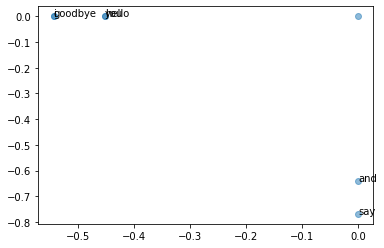

In [21]:
for word , word_id in word_to_id.items():
    plt.annotate(word , (U[word_id , 0] , U[word_id , 1]))

plt.scatter( U[:,0] , U[:,1] , alpha=0.5)
plt.show()

### 2-4-4 PTB 데이터셋

### 2-4-5 PTB 데이터셋 평가

In [ ]:
import sys
sys.path.append(add)
import numpy as np
from common.util import most_similar , create_co_matrix , ppmi
import dataset.ptb as ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id , id_to_ward = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus , vocab_size , window_size)
print('PPMI 계산 ...')
W = ppmi(C , verbose =True)

print('SVD 계산 ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U , S ,W  = randomized_svd(W , n_components = wordvec_size , n_iter = 5 , random_state = None)


except ImportError:
    # SVD (느리다)
    U ,S  ,V = np.linalg.svd(W)

word_vecs = U[: , :wordvec_size]

querys = ['you' , 'year' , 'car' , 'toyota']
for query in querys:
    most_similar(query , word_to_id , id_to_ward , word_vecs , top = 5)

Done
동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
